In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [2]:
import torch
import torchvision
print(torch.__version__)

2.5.1+cu118


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
data_dir = os.path.join(path, "eyepacs-aptos-messidor-diabetic-retinopathy")
num_epochs = 50
batch_size = 64
learning_rate = 1e-4
print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dataset root
data_dir = r"C:\Users\chittes\Downloads\DR_Dataset_extracted\augmented_resized_V2"

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

# DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes
print("Classes:", train_dataset.classes)


Classes: ['0', '1', '2', '3', '4']


In [7]:
import torch
import torch.nn as nn

class DRNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DRNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 7 * 7, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DRNet().to(device)

# Use BCELoss (NOT BCEWithLogitsLoss)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [9]:
from tqdm import tqdm
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.long().to(device)  # ✅ Use long tensor for multi-class

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: [B, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=running_loss/total, acc=correct/total)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(val_loss=val_loss/val_total, val_acc=val_correct/val_total)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        if scheduler:
            scheduler.step()

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        print(f"[{epoch+1:02}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [10]:
train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader
)

[01/50] Train Loss: 1.1350, Acc: 0.5771 | Val Loss: 1.0178, Acc: 0.6212


[02/50] Train Loss: 0.9581, Acc: 0.6404 | Val Loss: 0.8686, Acc: 0.6798


[03/50] Train Loss: 0.8664, Acc: 0.6747 | Val Loss: 0.8057, Acc: 0.7108


[04/50] Train Loss: 0.7884, Acc: 0.7037 | Val Loss: 0.7776, Acc: 0.7203


[05/50] Train Loss: 0.7544, Acc: 0.7169 | Val Loss: 0.7482, Acc: 0.7297


[06/50] Train Loss: 0.7241, Acc: 0.7274 | Val Loss: 0.7738, Acc: 0.7257


[07/50] Train Loss: 0.6723, Acc: 0.7464 | Val Loss: 0.7390, Acc: 0.7350


[08/50] Train Loss: 0.6489, Acc: 0.7558 | Val Loss: 0.7397, Acc: 0.7314


[09/50] Train Loss: 0.6286, Acc: 0.7630 | Val Loss: 0.7225, Acc: 0.7405


[10/50] Train Loss: 0.5929, Acc: 0.7761 | Val Loss: 0.7264, Acc: 0.7422


[11/50] Train Loss: 0.5786, Acc: 0.7827 | Val Loss: 0.7325, Acc: 0.7387


[12/50] Train Loss: 0.5636, Acc: 0.7879 | Val Loss: 0.7320, Acc: 0.7408


[13/50] Train Loss: 0.5401, Acc: 0.7973 | Val Loss: 0.7340, Acc: 0.7410


[14/50] Train Loss: 0.5327, Acc: 0.7996 | Val Loss: 0.7489, Acc: 0.7394


[15/50] Train Loss: 0.5264, Acc: 0.8018 | Val Loss: 0.7518, Acc: 0.7397


[16/50] Train Loss: 0.5136, Acc: 0.8076 | Val Loss: 0.7471, Acc: 0.7407


[17/50] Train Loss: 0.5085, Acc: 0.8098 | Val Loss: 0.7543, Acc: 0.7413


[18/50] Train Loss: 0.5050, Acc: 0.8106 | Val Loss: 0.7476, Acc: 0.7396


[19/50] Train Loss: 0.4979, Acc: 0.8137 | Val Loss: 0.7490, Acc: 0.7418


[20/50] Train Loss: 0.4961, Acc: 0.8134 | Val Loss: 0.7577, Acc: 0.7388


[21/50] Train Loss: 0.4927, Acc: 0.8165 | Val Loss: 0.7617, Acc: 0.7412


[22/50] Train Loss: 0.4898, Acc: 0.8159 | Val Loss: 0.7527, Acc: 0.7404


[23/50] Train Loss: 0.4893, Acc: 0.8165 | Val Loss: 0.7536, Acc: 0.7396


[24/50] Train Loss: 0.4889, Acc: 0.8173 | Val Loss: 0.7584, Acc: 0.7401


[25/50] Train Loss: 0.4857, Acc: 0.8180 | Val Loss: 0.7522, Acc: 0.7400


[26/50] Train Loss: 0.4858, Acc: 0.8183 | Val Loss: 0.7541, Acc: 0.7399


[27/50] Train Loss: 0.4854, Acc: 0.8177 | Val Loss: 0.7547, Acc: 0.7417


[28/50] Train Loss: 0.4836, Acc: 0.8189 | Val Loss: 0.7573, Acc: 0.7394


[29/50] Train Loss: 0.4834, Acc: 0.8196 | Val Loss: 0.7508, Acc: 0.7388


[30/50] Train Loss: 0.4833, Acc: 0.8192 | Val Loss: 0.7539, Acc: 0.7396


[31/50] Train Loss: 0.4830, Acc: 0.8188 | Val Loss: 0.7559, Acc: 0.7409


[32/50] Train Loss: 0.4831, Acc: 0.8197 | Val Loss: 0.7550, Acc: 0.7410


[33/50] Train Loss: 0.4833, Acc: 0.8181 | Val Loss: 0.7563, Acc: 0.7401


[34/50] Train Loss: 0.4830, Acc: 0.8194 | Val Loss: 0.7606, Acc: 0.7412


[35/50] Train Loss: 0.4826, Acc: 0.8200 | Val Loss: 0.7578, Acc: 0.7404


[36/50] Train Loss: 0.4831, Acc: 0.8198 | Val Loss: 0.7576, Acc: 0.7401


[37/50] Train Loss: 0.4830, Acc: 0.8185 | Val Loss: 0.7582, Acc: 0.7406


[38/50] Train Loss: 0.4819, Acc: 0.8191 | Val Loss: 0.7588, Acc: 0.7406


[39/50] Train Loss: 0.4848, Acc: 0.8190 | Val Loss: 0.7572, Acc: 0.7397


[40/50] Train Loss: 0.4815, Acc: 0.8195 | Val Loss: 0.7583, Acc: 0.7406


[41/50] Train Loss: 0.4825, Acc: 0.8198 | Val Loss: 0.7570, Acc: 0.7408


[42/50] Train Loss: 0.4818, Acc: 0.8198 | Val Loss: 0.7564, Acc: 0.7382


[43/50] Train Loss: 0.4820, Acc: 0.8195 | Val Loss: 0.7579, Acc: 0.7410


[44/50] Train Loss: 0.4825, Acc: 0.8202 | Val Loss: 0.7563, Acc: 0.7404


[45/50] Train Loss: 0.4821, Acc: 0.8194 | Val Loss: 0.7567, Acc: 0.7407


[46/50] Train Loss: 0.4811, Acc: 0.8210 | Val Loss: 0.7563, Acc: 0.7400


[47/50] Train Loss: 0.4829, Acc: 0.8193 | Val Loss: 0.7588, Acc: 0.7410


[48/50] Train Loss: 0.4813, Acc: 0.8201 | Val Loss: 0.7585, Acc: 0.7410


[49/50] Train Loss: 0.4823, Acc: 0.8196 | Val Loss: 0.7549, Acc: 0.7409


[50/50] Train Loss: 0.4809, Acc: 0.8200 | Val Loss: 0.7559, Acc: 0.7413


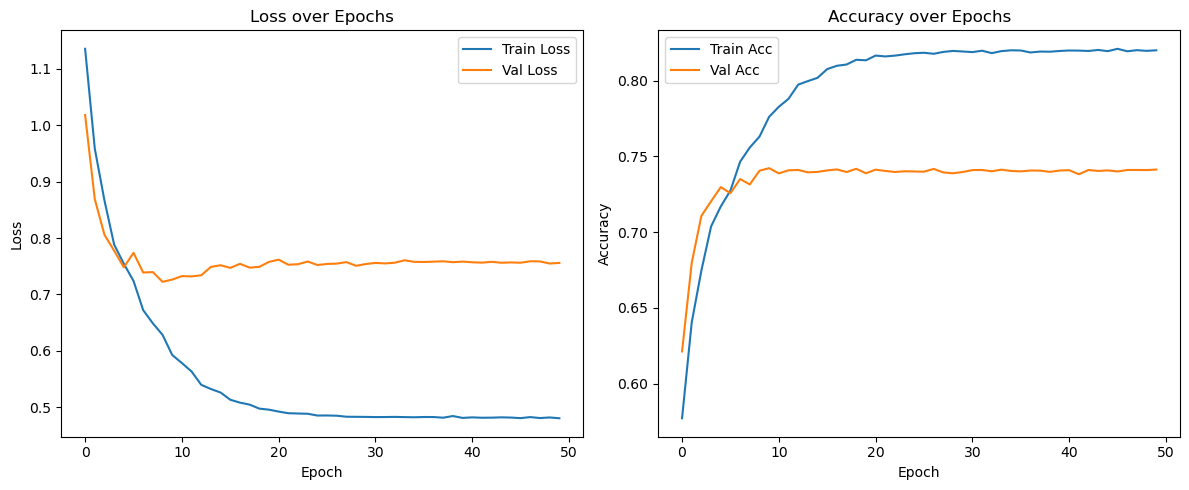

In [11]:
epochs = range(num_epochs)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, dataloader, criterion, device, class_names=None):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs)  # [batch_size, num_classes]
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)  # [batch_size]
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if total == 0:
        print("❌ Test set is empty.")
        return None

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Overall metrics
    accuracy = (all_preds == all_labels).sum() / total
    avg_loss = total_loss / total

    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print("\n📊 Overall Test Metrics")
    print(f"✅ Accuracy  : {accuracy * 100:.2f}%")
    print(f"📉 Loss      : {avg_loss:.4f}")
    print(f"📊 Precision : {precision_macro:.4f} (macro avg)")
    print(f"📊 Recall    : {recall_macro:.4f} (macro avg)")
    print(f"📊 F1 Score  : {f1_macro:.4f} (macro avg)")

    # Per-class metrics
    print("\n📋 Per-Class Metrics")
    if class_names is None:
        class_names = [f"Class {i}" for i in range(5)]  # default to Class 0, Class 1, ...

    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    )
    print(report)

    return {
        "accuracy": accuracy,
        "loss": avg_loss,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "classification_report": report
    }


# Define your 5 class labels if needed
class_names = ['0', '1', '2', '3', '4']

# Call the function
results = evaluate_model(model, test_loader, nn.CrossEntropyLoss(), device, class_names)



📊 Overall Test Metrics
✅ Accuracy  : 64.13%
📉 Loss      : 1.3756
📊 Precision : 0.5012 (macro avg)
📊 Recall    : 0.4886 (macro avg)
📊 F1 Score  : 0.4860 (macro avg)

📋 Per-Class Metrics
              precision    recall  f1-score   support

           0     0.8015    0.9565    0.8721      6896
           1     0.3388    0.3851    0.3605      1862
           2     0.3919    0.2104    0.2738      2999
           3     0.4003    0.2935    0.3386       978
           4     0.5733    0.5975    0.5852      1466

    accuracy                         0.6413     14201
   macro avg     0.5012    0.4886    0.4860     14201
weighted avg     0.6031    0.6413    0.6123     14201

